# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

In [405]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing, model_selection, metrics, ensemble
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [406]:
train = pd.read_csv('Train.csv')
num_columns = train.columns[:190]
cat_columns = train.columns[190:230]
y = train['label']

In [18]:
y

0       -1
1       -1
2       -1
3       -1
4        1
        ..
29995   -1
29996   -1
29997    1
29998   -1
29999   -1
Name: label, Length: 30000, dtype: int64

In [407]:
def num_features(df):
    
    for col in num_columns:
        if col in df.columns:
            #df = df.fillna(0)
            mean = df[col].dropna().mean()
            df[col] = df[col].fillna(mean)
            scaler = StandardScaler()
            df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
            
    return df

In [408]:
def cat_features(df):
    for col in cat_columns:
        if col in df.columns:
        # отбираем только те призники в которых количество различных категорий в (1;7)
            if len(np.unique(df[col].astype(str))) > 2 and len(np.unique(df[col].astype(str))) < 7:
                df = df.fillna('0')
            else:
                df = df.drop(col,axis=1)
    return df

In [409]:
def label_encoder(df):
    labelencoder = LabelEncoder()
    for i in cat_columns:
        if i in df.columns:
            df[i] = labelencoder.fit_transform(df[i].astype(str))
       
    return df

In [320]:
def one_hot_encoder(df):
    encoder = OneHotEncoder()
    for i in cat_columns:
        if i in df.columns:
            var = df[[i]].fillna('na')
            
            new_var = encoder.fit_transform(var).toarray()
            df = pd.concat(
                [
                    df, 
                    pd.DataFrame(
                        new_var,
                        columns = [i+'-'+str(j) for j in range(len(encoder.categories_[0]))]
                    )
                ], 
                axis=1,
                sort=False,
            )
            df = df.drop(i, axis=1)
    return df

In [410]:
estimator= GradientBoostingClassifier()

In [411]:
skf = model_selection.StratifiedKFold(n_splits=5, random_state=19,shuffle=True)

In [323]:
# рассчет метрик по кросс-валидации
def get_model_weight(clf, skf, x, y, weight=None):
    roc_auc = []
    f1_score = []
    precision = []
    recall = []
    weights = list(map(lambda x: weight[0] if x == -1 else weight[1], y))
    weights_class = pd.DataFrame(weights)
    for train, test in skf.split(x,y):
        clf.fit(x.iloc[train,:], y[train],sample_weight=weights_class.iloc[train,0])
        y_pred = clf.predict(x.iloc[test,:])
        y_pred_prob = clf.predict_proba(x.iloc[test,:])[:,1]
        precision.append(metrics.precision_score(y[test], y_pred))
        recall.append(metrics.recall_score(y[test], y_pred))
        f1_score.append(metrics.f1_score(y[test], y_pred))
        roc_auc.append(metrics.roc_auc_score(y[test], y_pred_prob))
        
    print('f1_score:', np.mean(f1_score))
    print('precision:', np.mean(precision))
    print('recall:', np.mean(recall))
    print('roc_auc:', np.mean(roc_auc))
        
    return roc_auc

## Инструкции

### 1. Как много объектов действительно нужно для построения качественной модели?

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [62]:
# подготовка данных
x1 = train.copy().drop('label',axis=1)
x1 = x1.dropna(axis=1, how='all')
x1 = num_features(x1)
x1 = cat_features(x1)
x1 = label_encoder(x1)

In [76]:
train_sizes, train_scores, test_scores = learning_curve(estimator, x1, y, cv=5, 
                                                        scoring='roc_auc', 
                                                        train_sizes=np.arange(0.1, 1, 0.1), n_jobs=-1)

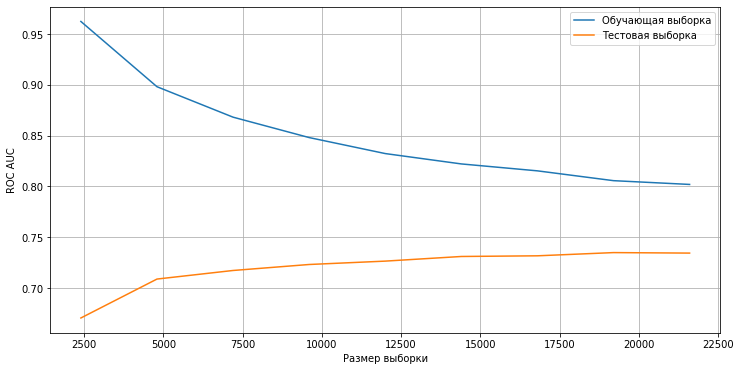

In [77]:
plt.figure(figsize=(12,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label=u"Обучающая выборка")
plt.plot(train_sizes, test_scores.mean(axis=1), label=u"Тестовая выборка")
plt.legend(loc='best')
plt.grid()
plt.xlabel(u'Размер выборки')
plt.ylabel(u'ROC AUC')
plt.show()

Как видно из графика, метрика на тестовой выборке продолжает расти с увеличением обучающей выборки,хотя и не значительно. Для дальнейшей работы берем все данные

### 2. Балансировка выборки

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

В исходной выборке соотношение классов отток("1") и не_отток("-1") составляет примерно 1:12. Воспользуемся параметром class_weight в логистической регрессии и посмотрим на что он влияет:

In [103]:
# задаем соотношение весов отток:не_отток
weights = [[1, 12],
           [1, 5],
           [1, 3],
           [1, 1],
           [3, 1],
           [12, 1]]
        

In [110]:
for weight in weights:
    print ('соотношение весов:', weight)
    roc_auc = get_model_weight(estimator, skf, x1, y, weight)
    print('\n')

соотношение весов: [1, 12]
f1_score: 0.24288645721586608
precision: 0.14943667381081496
recall: 0.6484952766531713
roc_auc: 0.7339751875087852


соотношение весов: [1, 5]
f1_score: 0.255363942689078
precision: 0.25801836187655525
recall: 0.2535039521881627
roc_auc: 0.7363258899369104


соотношение весов: [1, 3]
f1_score: 0.15580161380446383
precision: 0.33773916346199495
recall: 0.10193175245806825
roc_auc: 0.7367522174408091


соотношение весов: [1, 1]
f1_score: 0.032337466529396494
precision: 0.5594934640522876
recall: 0.016698476961634855
roc_auc: 0.735632851465557


соотношение весов: [3, 1]
f1_score: 0.014373230830977857
precision: 0.1954924023345076
recall: 0.007469635627530365
roc_auc: 0.7341082940580207


соотношение весов: [12, 1]
f1_score: 0.028665615161532397
precision: 0.12183640920483026
recall: 0.01625602467707731
roc_auc: 0.728915401716049




Изменяя веса каждого класса, мы в большей степени влияем на точность и полноту, чем на остальные метрики.

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [412]:
def undersampling_alpha(df, alpha):
    data_churn = df[df['label'] == 1]
    data_nochurn = df[df['label'] == -1]
    countFirst = int(len(data_churn) * alpha)
    data_churn = data_churn.append(data_nochurn.iloc[:countFirst,:])
    data_churn = shuffle(data_churn)
    return data_churn

In [413]:
def get_model(clf, skf, x, y):
    roc_auc = []
    f1_score = []
    precision = []
    recall = []
    for train, test in skf.split(x,y):
        clf.fit(x.iloc[train,:], y[train])
        y_pred = clf.predict(x.iloc[test,:])
        y_pred_prob = clf.predict_proba(x.iloc[test,:])[:,1]
        precision.append(metrics.precision_score(y[test], y_pred))
        recall.append(metrics.recall_score(y[test], y_pred))
        f1_score.append(metrics.f1_score(y[test], y_pred))
        roc_auc.append(metrics.roc_auc_score(y[test], y_pred_prob))
        
    print('f1_score:', np.mean(f1_score))
    print('precision:', np.mean(precision))
    print('recall:', np.mean(recall))
    print('roc_auc:', np.mean(roc_auc))
        
    return roc_auc

In [128]:
alphas = [0.5, 1, 2, 5, 11]
for alpha in alphas:
    data_sample = train.copy()
    data_sample = data_sample.dropna(axis=1, how='all')
    data_sample = num_features(data_sample)
    data_sample = cat_features(data_sample)
    data_sample = label_encoder(data_sample)
    data_sample = undersampling_alpha(data_sample, alpha)
    x2 = data_sample.iloc[:,:-1]
    y2 = data_sample.iloc[:,-1:]
    print ('alpha:', alpha)
    roc_auc = get_model(estimator, skf, x2,  y2.label.values)
    print('\n')
    

alpha: 0.5
f1_score: 0.8073168277432744
precision: 0.7318090091665831
recall: 0.9002708694813958
roc_auc: 0.73140615007529


alpha: 1
f1_score: 0.6811694432013102
precision: 0.6681189858110372
recall: 0.6964208598419125
roc_auc: 0.7332149975530541


alpha: 2
f1_score: 0.4377576364219994
precision: 0.6270572422011023
recall: 0.33656352419510316
roc_auc: 0.7296378166550388


alpha: 5
f1_score: 0.1301089334699283
precision: 0.5791649407799592
recall: 0.07337285521496048
roc_auc: 0.7282116795385111


alpha: 11
f1_score: 0.03960681534257317
precision: 0.5208187134502924
recall: 0.020649701176016964
roc_auc: 0.7343263449638586




Основная метрика (ROC AUC) практически не меняется, если выбрасывать объекты доминирующего класса, зато сильно растут точность и полнота.

### 3. Обработкa пропущенных значений


3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Начнем с числовых признаков

In [11]:
x3 = train[num_columns].copy()
x3 = x3.dropna(axis=1, how='all')

In [105]:
# замена nan на средние значения
x3_mean = x3.fillna(x3.mean())
x3_mean = pd.DataFrame(StandardScaler().fit_transform(x3_mean))
roc_auc = get_model(estimator, skf, x3_mean, y)

f1_score: 0.009527735607390482
precision: 0.36666666666666664
recall: 0.0048332369385000965
roc_auc: 0.7188997559469061


In [106]:
# замена nan на медианное значения
x3_median = x3.fillna(x3.median())
x3_median = pd.DataFrame(StandardScaler().fit_transform(x3_median))
roc_auc = get_model(estimator, skf, x3_median, y)

f1_score: 0.005208001053372327
precision: 0.22857142857142856
recall: 0.0026363986890302676
roc_auc: 0.7098278701598252


In [21]:
# замена nan на нулевое значения
x3_zero = x3.fillna(0)
x3_zero = pd.DataFrame(StandardScaler().fit_transform(x3_zero))
roc_auc = get_model(estimator, skf, x3_zero, y)

f1_score: 0.0077942005282960235
precision: 0.32857142857142857
recall: 0.003952188162714478
roc_auc: 0.7161720525586325


Среднее значение показывает лучший результат по основной метрике. Добавим дополнительный признак -- пропущено ли значение в исходной таблице и опять посчитаем метрики:

In [16]:
x3_nan = x3.isnull()
x3_nan.columns = ['nan_'] + x3_nan.columns

In [22]:
# замена nan на средние значения
roc_auc = get_model(estimator, skf, pd.concat([x3_mean, x3_nan], axis=1), y)

f1_score: 0.005202423511411133
precision: 0.22333333333333333
recall: 0.0026354347406978987
roc_auc: 0.7181666493263563


In [23]:
# замена nan на медианное значения
roc_auc = get_model(estimator, skf, pd.concat([x3_median, x3_nan], axis=1), y)

f1_score: 0.00521551326473352
precision: 0.25
recall: 0.0026354347406978987
roc_auc: 0.7191123056439427


In [24]:
# замена nan на нулевое значения
roc_auc = get_model(estimator, skf, pd.concat([x3_zero, x3_nan], axis=1), y)

C:\Users\chetv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1_score: 0.006049475262368815
precision: 0.205
recall: 0.00307210333526123
roc_auc: 0.7159709878922036


Существеннной разницы после добавления доп.признака не наблюдается.

Вывод: в дальнейшем заменяем пропуски на средние значения

### 4. Обработкa категориальный признаков

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [414]:
data_4 = train.copy()
data_4 = data_4.dropna(axis=1, how='all')
data_4 = num_features(data_4)
data_4 = cat_features(data_4)

In [97]:
# one_hot_encoder
data_4_one_hot_encoder = one_hot_encoder(data_4)
data_4_one_hot_encoder.drop('label', axis=1, inplace=True)
data_4_one_hot_encoder['label'] = data_4.label


data_4_one_hot_encoder = undersampling_alpha(data_4_one_hot_encoder, 1)

x_one_hot_encoder = data_4_one_hot_encoder.iloc[:,:-1]
y_one_hot_encoder = data_4_one_hot_encoder.iloc[:,-1:]

In [101]:
roc_auc = get_model(estimator, skf, x_one_hot_encoder, y_one_hot_encoder.label.values)

f1_score: 0.679048907939561
precision: 0.6672194449204488
recall: 0.6915664160401004
roc_auc: 0.7301571331117312


In [415]:
# label_encoder
data_4_label_encoder = label_encoder(data_4)

data_4_label_encoder = undersampling_alpha(data_4_label_encoder, 1)

x_label_encoder = data_4_label_encoder.iloc[:,:-1]
y_label_encoder = data_4_label_encoder.iloc[:,-1:]

In [102]:
roc_auc = get_model(estimator, skf, x_label_encoder, y_label_encoder.label.values)

f1_score: 0.6796461004093987
precision: 0.6675689743803389
recall: 0.6924301137459032
roc_auc: 0.7349229561647144


Кодирование с помощью label_encoder показала результат по основной метрике несколько выше, чем one_hot_encoder. В дальнейшем используем label_encoder, так как он впридачу менее восприимчим к данным с большим количеством различных категории, в то время как one_hot_encoder сильно бы увеличил размерность dataframe

### 5. Отбор признаков

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [326]:
from sklearn.feature_selection import SelectKBest, SelectFromModel

In [327]:
x5 = x_label_encoder.copy()
y5 = y_label_encoder.copy()

In [127]:
x5.shape

(4552, 185)

In [328]:
kbest50 = SelectKBest(k=50).fit_transform(x5, y5.label.values)
kbest100 = SelectKBest(k=100).fit_transform(x5, y5.label.values)
kbest150 = SelectKBest(k=150).fit_transform(x5, y5.label.values)

C:\Users\chetv\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [106] are constant.
  UserWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [106] are constant.
  UserWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [106] are constant.
  UserWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [135]:
roc_auc = get_model(estimator, skf, pd.DataFrame(kbest50), y5.label.values)

f1_score: 0.6774577084657615
precision: 0.6641216423652557
recall: 0.6915509928667822
roc_auc: 0.7329516924178578


In [136]:
roc_auc = get_model(estimator, skf, pd.DataFrame(kbest100), y5.label.values)

f1_score: 0.6734460437423888
precision: 0.6612112316412785
recall: 0.6862781954887218
roc_auc: 0.7333088172671747


In [137]:
roc_auc = get_model(estimator, skf, pd.DataFrame(kbest150), y5.label.values)

f1_score: 0.6789695210242581
precision: 0.6675645030080235
recall: 0.6911056487372276
roc_auc: 0.7360448596131072


Отбор при помощи l1 

In [140]:
from sklearn.linear_model import Lasso

In [146]:
lasso = Lasso(alpha=0.01).fit(x5,y5)
model = SelectFromModel(lasso, prefit=True)
x5_upd = model.transform(x5)

In [149]:
roc_auc = get_model(estimator, skf, pd.DataFrame(x5_upd), y5.label.values)

f1_score: 0.6796074946286205
precision: 0.664101262467943
recall: 0.6959514170040487
roc_auc: 0.73428725766233


Вывод: большинство признаков оказались бесполезными, качество моделей не повысилось, но удалось заметно сократить размерность датасета

### 6. Настройка гиперпараметров модели

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

Текущий наилучший результат:
    - предварительный отбор категориальных признаков (удаление признаков с одной и очень большим количеством категорий)
    - LabelEncoding
    - заполнение пропусков средним значение и стандартизация для количественных признаков
    - соотношение классов 1:1, хотя вариант как в исходной тоже имеет место быть, однако от этого пострадают другие метрики

In [416]:
x5 = x_label_encoder.copy()
y5 = y_label_encoder.copy()

In [417]:
data_4_label_encoder_no_undersampling = label_encoder(data_4)
x_label_encoder_no_undersampling = data_4_label_encoder_no_undersampling.iloc[:,:-1]
y_label_encoder_no_undersampling = data_4_label_encoder_no_undersampling.iloc[:,-1:]
x6 = x_label_encoder_no_undersampling.copy()
y6 = y_label_encoder_no_undersampling.copy()

In [151]:
# параметры для GridSearch для gradientboosting
grad_gb_params = {
    'n_estimators' : np.arange(100, 1000, 200),
    'learning_rate' : [0.1, 0.01, 0.05],
    'subsample' : [0.3, 0.5, 0.8, 1.0],
    'max_depth' : [3, 5, 8]
}

In [158]:
# поиск для сетки по выборке с undersampling
grid_cv_gb_undersampling = model_selection.GridSearchCV(estimator, grad_gb_params,
                                                        n_jobs=-1, verbose=10, cv=skf, scoring='roc_auc')
grid_cv_gb_undersampling.fit(x5, y5.label.values)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  7

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  mi...
                                                  random_state=None,
                                   

In [159]:
print('best score:', grid_cv_gb_undersampling.best_score_)
print('best param:', grid_cv_gb_undersampling.best_params_)

best score: 0.7400086712978557
best param: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 700, 'subsample': 0.5}


In [160]:
# поиск для сетки по выборке без undersampling
grid_cv_gb_no_undersampling = model_selection.GridSearchCV(estimator, grad_gb_params,
                                                           n_jobs=-1, verbose=10, cv=skf, scoring='roc_auc')
grid_cv_gb_no_undersampling.fit(x6, y6.label.values)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 43.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 55

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  mi...
                                                  random_state=None,
                                   

In [161]:
print('best score:', grid_cv_gb_no_undersampling.best_score_)
print('best param:', grid_cv_gb_no_undersampling.best_params_)

best score: 0.7376342552051642
best param: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 700, 'subsample': 0.8}


In [292]:
# попробуем xgboost
bst = XGBClassifier(n_estimators=700)
params = {'max_depth': [2, 3, 4],
          'learning_rate': [0.05, 0.1, 0.01],
          'subsample': [0.8, 1.0, 0.5]}

xgb_grid = model_selection.GridSearchCV(bst, params, scoring = 'roc_auc', cv=3, n_jobs=-1, verbose=1)
xgb_grid.fit(x5, y5.label.values)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  7.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,

In [294]:
xgb_grid.best_score_

0.7372706322934649

In [276]:
xgb_grid.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 700, 'subsample': 0.8}

Настройка гиперпараметров позволила незначительно повысить качество.

### 7. Вклад признаков

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [418]:
xgb_estimator = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=700, subsample=0.8)
xgb_estimator.fit(x5, y5.label.values)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=700, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
              validate_parameters=False, verbosity=None)

In [419]:
# определяем важность признаков, подход через feature_importance
importance = pd.DataFrame(xgb_estimator.feature_importances_, columns=['importance'])
importance['label'] = x5.columns.values
importance.sort_values('importance', inplace=True, ascending=False)
importance.head(10)

,importance,label
114,0.053477,Var126
63,0.034610,Var74
11,0.034511,Var13
62,0.027792,Var73
181,0.025542,Var218
172,0.023110,Var189
178,0.019520,Var205
184,0.019196,Var229
17,0.015583,Var21
101,0.015097,Var113


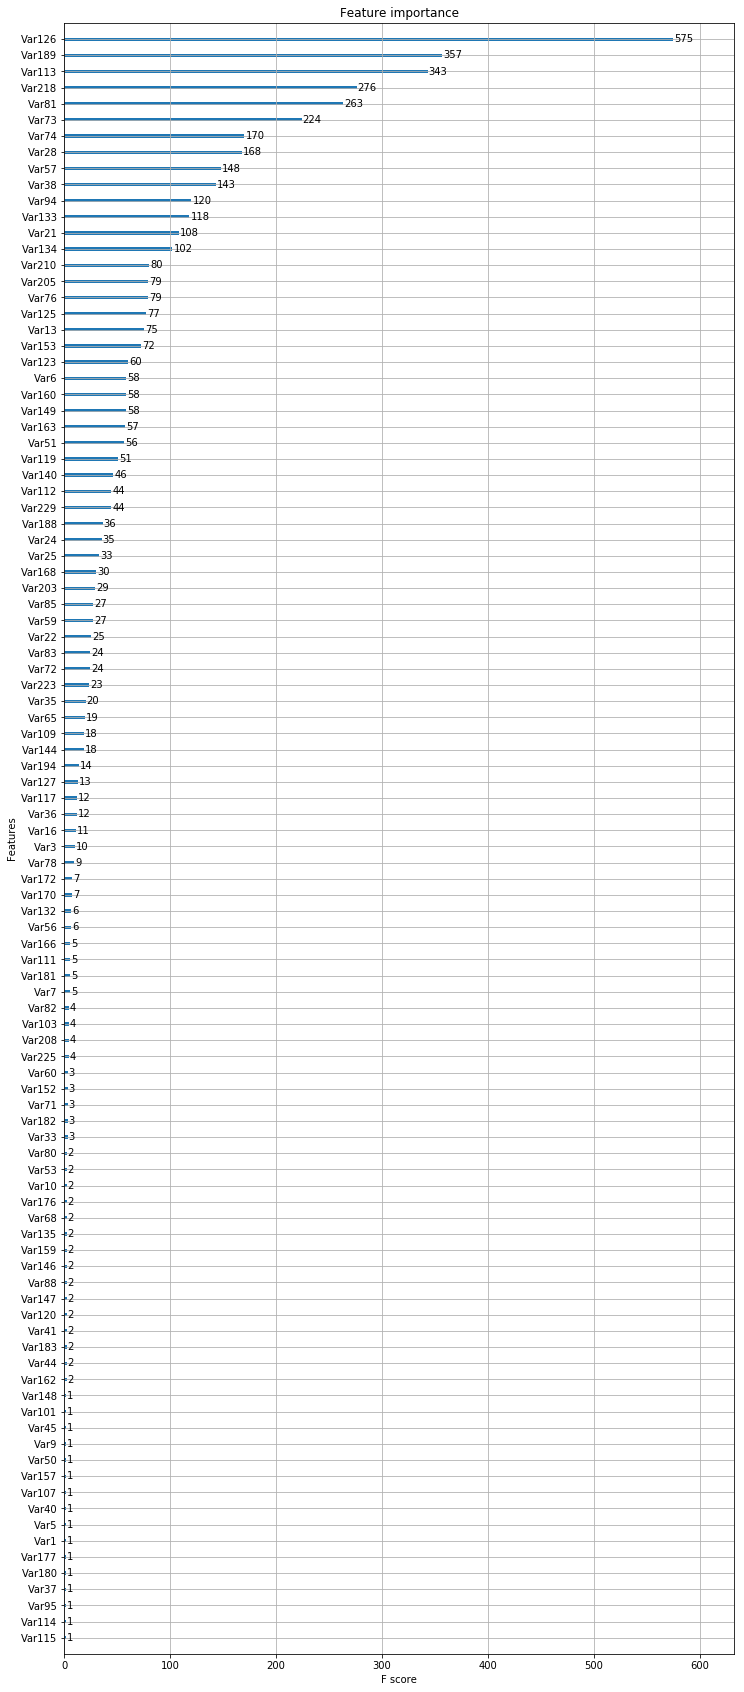

In [17]:
# определяем важность признаков, подход через метод plot_importance библиотеки xgboost
fig, ax = plt.subplots(figsize=(12, 30))
xgb.plot_importance(xgb_estimator, ax=ax)
plt.show()

Большенство признаков являются неинформативными. Для посторении модели без существенной потери качества можно смело оставлять ~30 шт наиболее информативных по одному из показанных подходов.

### 8. Анализ ошибок классификации

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [336]:
import itertools

Confusion matrix, without normalization
[[18084  9640]
 [  587  1689]]


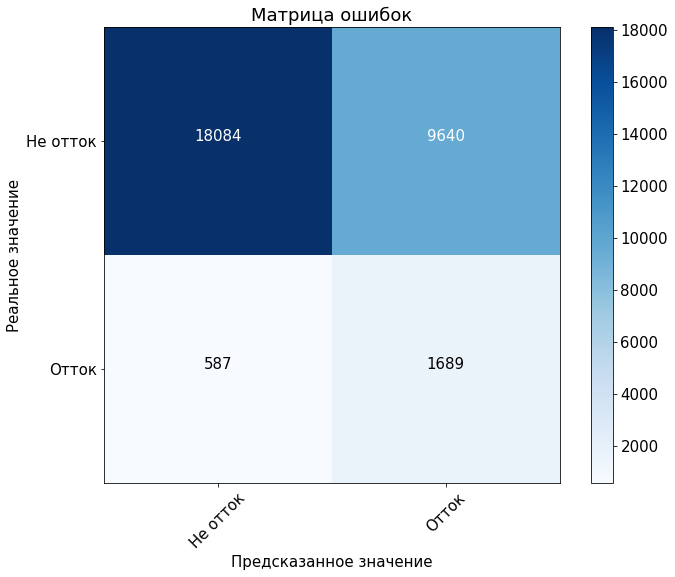

In [366]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Реальное значение')
    plt.xlabel('Предсказанное значение')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = metrics.confusion_matrix(y6.label.values, xgb_estimator.predict(x6))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Не отток', 'Отток'],
                      title='Матрица ошибок')
plt.savefig("conf_matrix.png")
plt.show()

In [382]:
x6

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var196,Var201,Var203,Var205,Var208,Var210,Var218,Var223,Var225,Var229
0,-3.761848e-16,-6.013185e-17,0.0,9.820395e-17,4.901509e-16,-0.236062,4.456295e-02,3.639485e-16,-8.081573e-16,0.0,...,0,0,1,0,1,5,1,4,0,0
1,-3.761848e-16,-6.013185e-17,0.0,9.820395e-17,4.901509e-16,-0.212918,4.456295e-02,3.639485e-16,-8.081573e-16,0.0,...,0,0,1,2,1,5,2,1,0,1
2,-3.761848e-16,-6.013185e-17,0.0,9.820395e-17,4.901509e-16,-0.351781,2.424859e+00,3.639485e-16,-8.081573e-16,0.0,...,0,0,1,2,1,5,2,1,1,1
3,-3.761848e-16,-6.013185e-17,0.0,9.820395e-17,4.901509e-16,-0.609671,-1.145585e+00,3.639485e-16,-8.081573e-16,0.0,...,0,0,1,1,1,5,2,1,0,0
4,-3.761848e-16,-6.013185e-17,0.0,9.820395e-17,4.901509e-16,0.236736,4.456295e-02,3.639485e-16,-8.081573e-16,0.0,...,0,0,1,2,1,5,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-3.761848e-16,-6.013185e-17,0.0,9.820395e-17,4.901509e-16,-0.275737,4.456295e-02,3.639485e-16,-8.081573e-16,0.0,...,0,2,1,2,1,5,1,1,3,1
29996,-3.761848e-16,-6.013185e-17,0.0,9.820395e-17,-2.188796e+00,0.000000,-1.510091e-16,3.639485e-16,-2.454213e+00,0.0,...,0,0,1,1,1,5,1,1,0,0
29997,-3.761848e-16,-6.013185e-17,0.0,9.820395e-17,4.901509e-16,0.279717,4.456295e-02,3.639485e-16,-8.081573e-16,0.0,...,0,2,1,3,1,5,1,1,2,2
29998,-3.761848e-16,-6.013185e-17,0.0,9.820395e-17,4.901509e-16,-0.285656,-1.145585e+00,3.639485e-16,-8.081573e-16,0.0,...,0,0,1,2,1,5,2,1,0,0


In [420]:
data_with_predict = x6.copy()
data_with_predict['labels'] = y6.copy()
data_with_predict['predicted'] = xgb_estimator.predict(x6.iloc[:,:185])
data_with_predict['probability'] = xgb_estimator.predict_proba(x6.iloc[:,:185])[:,1]

In [421]:
# возвращает объекты, на которых совершены ошибки первого и второго рода
# параметры thresh_1 и thresh_2 - пороги для объектов, на которых модель совершила наибольшую ошибку
def errorObjects(data, thresh_1, thresh_2):
    df_first_type_err = pd.DataFrame([])
    df_second_type_err = pd.DataFrame([])
    for sample in range(len(data)):
        if (data['labels'][sample] == 1.0) and (data['predicted'][sample] == -1.0):
            if abs(1-data['probability'][sample]) > thresh_1:
                df_first_type_err = df_first_type_err.append(data.loc[sample])
        if (data['labels'][sample] == -1.0) and (data['predicted'][sample] == 1.0):
            if abs(data['probability'][sample]) > thresh_2:
                df_second_type_err = df_second_type_err.append(data.loc[sample])
    print ('size of first type error samples: ', str(len(df_first_type_err)))
    print ('size of second type error samples: ', str(len(df_second_type_err)))
    return(df_first_type_err, df_second_type_err)

In [422]:
first_type_err, second_type_err = errorObjects(data_with_predict, 0.3, 0.001)


size of first type error samples:  573
size of second type error samples:  9715


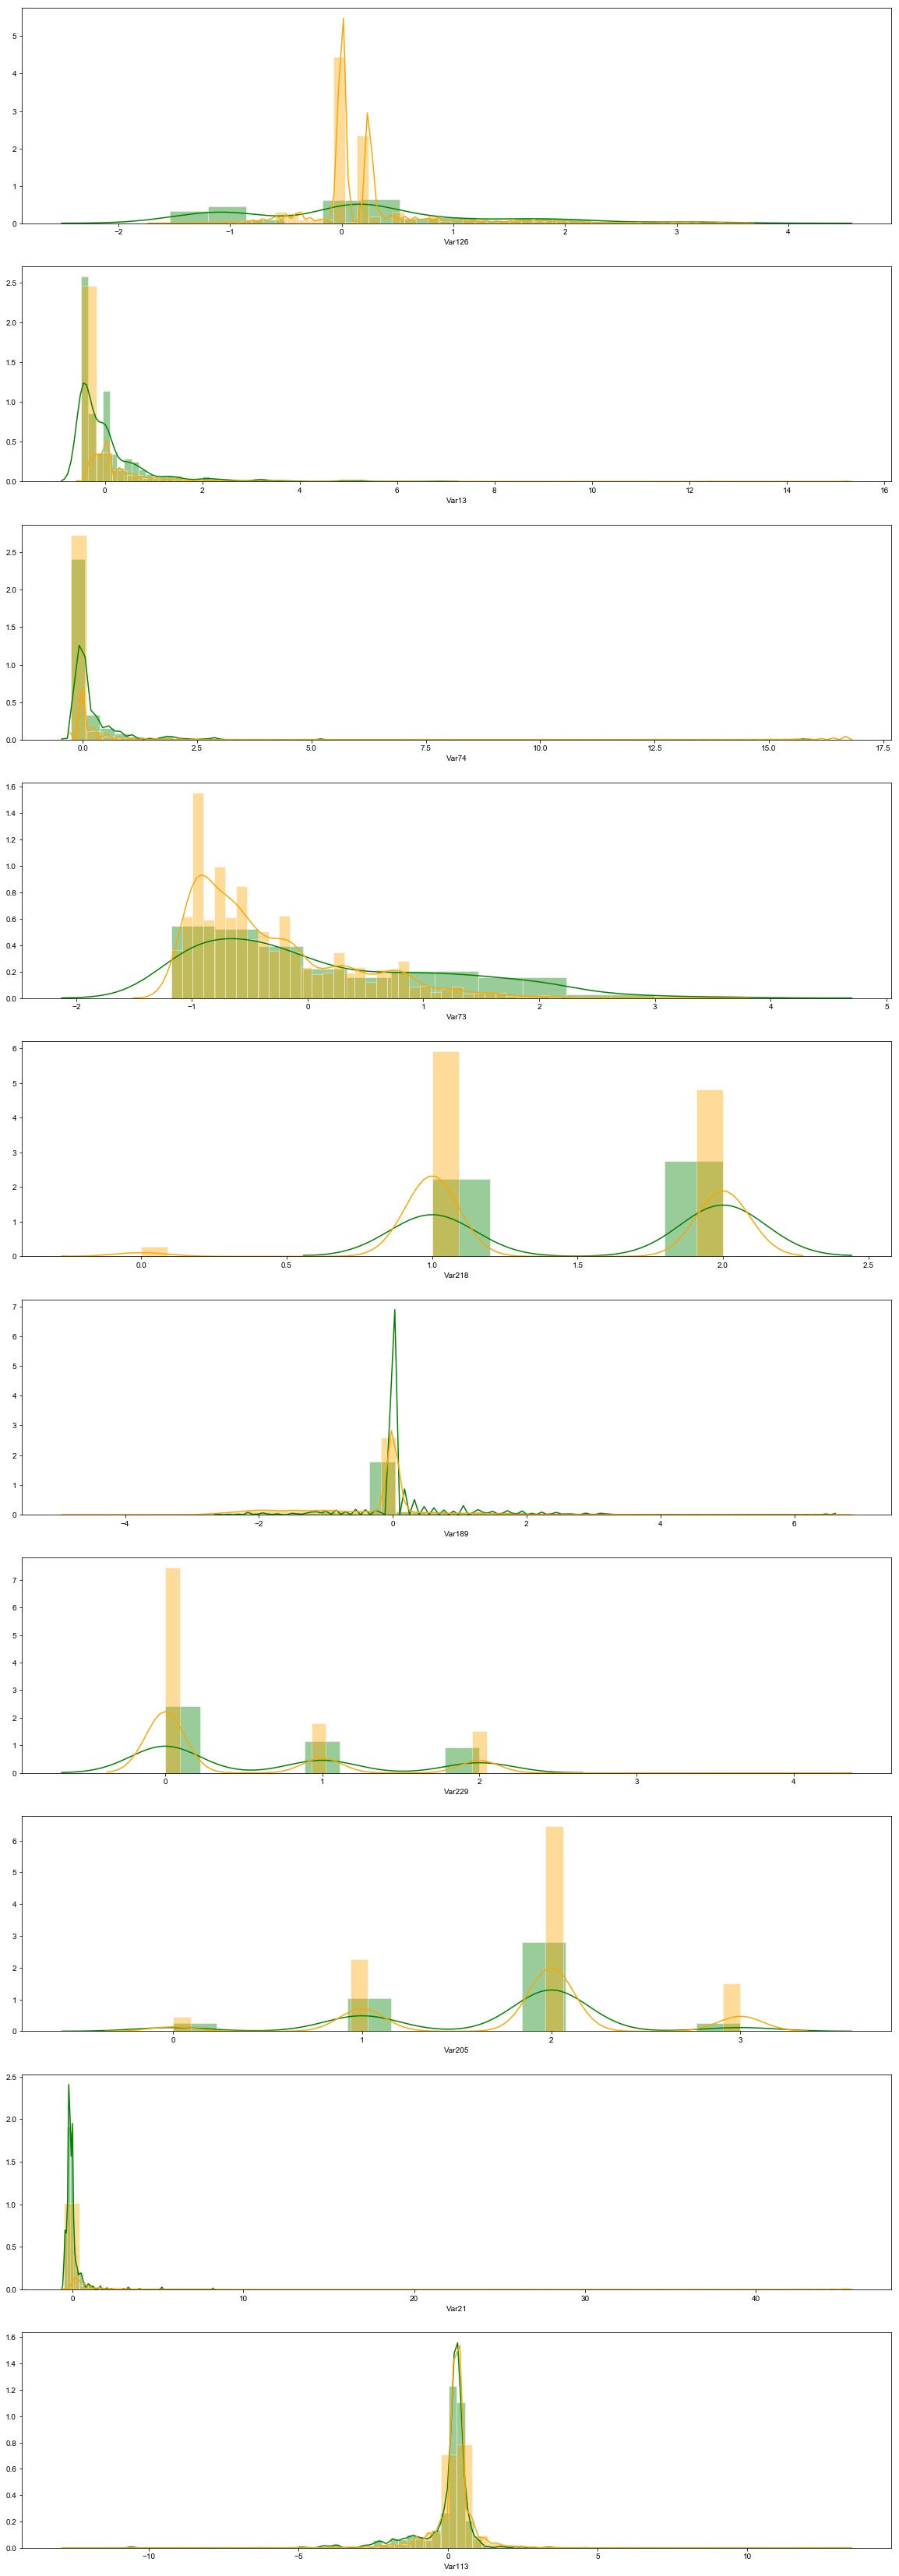

In [21]:
fig, axs = plt.subplots(10, figsize = (20,60))
sns.set(color_codes=True)
for ax, column in zip(axs,  importance.iloc[:10,1]):
    sns.distplot(first_type_err[column][data_with_predict['labels'] == 1], ax = ax, color = "green", label = str(column)+" label = 1")
    sns.distplot(second_type_err[column][data_with_predict['labels'] == -1], ax = ax, color = "orange", label = str(column)+" label = -1")

Вывод: Построенная модель допускает большое количество ошибок первого и второго рода, преимущственно второго (приравнивание лояльного клиента за уходящего, может вызывать дополнительные затраты на ненужное удержание).
Объекты на которых совершена наибольшая ошибка похожи между собой, это видно на гистограммах. Для данной модели следует подбирать порог, чтобы подобрать соотношение ошибок первого/второго рода. Объекты, на которых совершена ошибка второго рода, скорее всего, являются выбросами

### 9. Финальная модель

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

- удаление неинформативных признаков, особенно категориальных
- замена пропусков на средние значение
- labelencoding для категориальных
- xgboost_classifier 
- подбор гиперпараметров по сетке 
- построение решения по 30 наиболее информативным признакам

In [423]:
data_final = train.copy()
data_final = data_final.dropna(axis=1, how='all')
data_final = num_features(data_final)
data_final = cat_features(data_final)
data_final = label_encoder(data_final)
x_final = data_final.iloc[:,:-1]
y_final = data_final.iloc[:,-1:]

In [425]:
xgb_estimator = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=700, subsample=0.8)
roc_auc = get_model(xgb_estimator, skf, x_final[importance['label'][:30]], y_final.label.values)

f1_score: 0.013913142107560183
precision: 0.7057142857142857
recall: 0.007031039136302294
roc_auc: 0.7394056820604178


In [428]:
x_final[importance['label'][:30]]

,Var126,Var74,Var13,Var73,Var218,Var189,Var205,Var229,Var21,Var113,...,Var153,Var147,Var172,Var59,Var188,Var159,Var127,Var203,Var51,Var38
0,1.186019e+00,-2.323950e-01,-0.469509,-0.382299,1,-1.012122e-15,0,0,-0.205802,0.549330,...,1.047529e+00,1.743381e-15,9.817693e-16,1.189313e-15,0.0,-5.364754e-16,-2.229877e-16,1,7.412927e-16,-5.825308e-01
1,3.466032e-01,-1.763262e-01,-0.342529,-0.306402,2,-5.412290e-01,2,1,-0.188552,0.088205,...,7.281226e-01,1.743381e-15,9.817693e-16,1.189313e-15,0.0,-5.364754e-16,-2.229877e-16,1,7.412927e-16,-2.520413e-02
2,1.920508e+00,-2.137054e-01,-0.298634,-0.116657,2,-1.012122e-15,2,1,-0.309302,0.330269,...,-1.330736e+00,1.743381e-15,9.817693e-16,1.189313e-15,0.0,-5.364754e-16,-2.229877e-16,1,7.412927e-16,-8.797803e-01
3,-1.437156e+00,-2.697742e-01,-0.485185,-1.027430,2,-1.012122e-15,1,0,-0.283427,-0.944186,...,-5.877413e-01,1.743381e-15,9.817693e-16,1.189313e-15,0.0,-5.364754e-16,-2.229877e-16,1,-2.137836e+00,-1.236345e-01
4,5.824619e-18,-1.950158e-01,-0.072892,1.401297,2,-1.012122e-15,2,1,0.535947,0.281173,...,-1.315356e+00,1.743381e-15,9.817693e-16,1.189313e-15,0.0,-5.364754e-16,-2.229877e-16,1,7.412927e-16,-7.788024e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-1.542083e+00,-8.119633e-03,0.638822,-0.002811,1,-1.609555e+00,2,1,-0.257552,0.371758,...,7.562007e-01,1.743381e-15,9.817693e-16,1.189313e-15,0.0,-5.364754e-16,-2.229877e-16,1,7.412927e-16,-9.025572e-01
29996,-1.122375e+00,-3.794220e-17,0.000000,-1.065379,1,4.202648e-01,1,0,0.000000,-1.589101,...,-2.261304e-16,-6.636799e+00,-5.421537e+00,1.189313e-15,0.0,-5.364754e-16,-2.229877e-16,1,7.412927e-16,1.632691e-16
29997,5.824619e-18,-1.389469e-01,0.019599,0.414627,1,-1.012122e-15,3,2,0.156447,0.254827,...,-1.814856e-01,1.743381e-15,9.817693e-16,1.189313e-15,0.0,-5.364754e-16,-2.229877e-16,1,7.412927e-16,-4.646702e-03
29998,2.416762e-01,-2.697742e-01,-0.485185,-0.723839,2,-1.012122e-15,2,0,-0.102302,0.558582,...,1.056852e+00,1.743381e-15,9.817693e-16,1.189313e-15,0.0,-5.364754e-16,-2.229877e-16,1,7.412927e-16,4.415621e-01


### 10. Усовершенствование модели

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Необходимо тщательно поработать с признаками, в особенности содержащие выбросы. Возможно поможет создание новых признаков, основанных на взаимодействии текущих. Подбор гиперпараметров алгоритма по всевозможным комбинациям. 

### 11. Проверка на kaggle

In [426]:
test_data_kaggle = pd.read_csv('orange_small_churn_test_data.csv',)
test_data_kaggle.drop('ID',axis=1, inplace=True)

In [427]:
test_data_kaggle = test_data_kaggle.dropna(axis=1, how='all')
test_data_kaggle = num_features(test_data_kaggle)
test_data_kaggle = cat_features(test_data_kaggle)
test_data_kaggle = label_encoder(test_data_kaggle)

In [441]:
estimator_best = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=700, subsample=0.5)
estimator_best.fit(x_final[importance['label'][:30]], y_final.label.values)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=700,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [442]:
y_test = pd.DataFrame({'ID': test_data_kaggle.index, 'result': estimator_best.predict_proba(test_data_kaggle[importance['label'][:30]])[:,1]})

In [443]:
y_test.to_csv('answer_upd.csv', index=False)

В результате удалось незначительно улучшить показатель на kaggle